# Project Implementation #

In [1]:
import zipfile
from PIL import Image, ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np

In [2]:
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# here are our query variables
query1, query2 = 'Christopher', 'Mark'

In [3]:
# lets read the contents of our zip archive and extract the image files
def getImages(zip_file):
    with zipfile.ZipFile(zip_file) as myzip:
        myzip_contents = myzip.infolist()    # contains "file-like" ZipInfo objects
        # access files in myzip using .open() or .extract() to directory, passing myzip_contents as parameters
        myzip_pages = []
        for zip_info in myzip_contents:
            page_image = Image.open(myzip.open(zip_info))
            myzip_pages.append({'img': page_image, 'info': zip_info})
        return myzip_pages
      
pages1 = getImages('readonly/small_img.zip')
pages2 = getImages('readonly/images.zip')

In [4]:
# parse the text of each image with OCR and append the resulting string to the corresponding dictionary
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\Lenovo\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'
def parseText(pages, mode = 'RGB'):
    for page in pages:
        page_text = pytesseract.image_to_string(page['img'].convert(mode))
        page['txt'] = page_text
        
parseText(pages1)
parseText(pages2)

In [5]:
# provided the page contains query, we look up faces in the image with openCV
def findFaces(page, scale_factor = 1.3, min_neighbors = 5):
    # get a numpy array from the file and use the binarization with an appropriate threshold value
    img_np = np.array(page['img'])
    img_gray = cv.cvtColor(img_np, cv.COLOR_BGR2GRAY)
    face_boxes = face_cascade.detectMultiScale(img_gray, scale_factor, min_neighbors)
    
    # from the list of boxes produce the actual face images
    page['fcs'] = []
    for (x,y,w,h) in face_boxes:
        face_img = page['img'].crop((x,y,x+w,y+h))
        page['fcs'].append(face_img)

In [6]:
# we will first construct the partial contact sheet for each individual file, corresponding to the given query parameter
# choose the sample size to which all the face images shoud be adjusted
width_step, height_step = 100, 100
caption_height = 30

# choose the number of face images to fit horizontally in the contact sheet
hor_span = 5

# choose the font for caption
fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", int(0.6*caption_height))

def partial_sheet(page, query, w = width_step, h = height_step, c = caption_height, hor = hor_span):
    findFaces(page)
    n = len(page['fcs'])
    ver = n // hor + int(n % hor != 0)    # multiplier for height, analogous to ceil() function of math module
    sheet = Image.new('RGB', (w*hor, c + c*int(n==0) + h*ver), color = 'white')
    x, y = 0, c
    for face in page['fcs']:
        # paste the current image into the contact sheet
        face.thumbnail((w, h), Image.ANTIALIAS)
        sheet.paste(face, (x, y))
        # update X, Y position, jumping to the next "line"
        if x + w == sheet.width:
            x, y = 0, y + h
        else:
            x = x + w
    # create caption
    caption = "Results found in file {} for query {}".format(page['info'].filename, query)
    draw = ImageDraw.Draw(sheet)
    draw.text((int(0.2*c), int(0.2*c)), caption, font = fnt, fill = 'black')
    if n == 0:
        erratum = "But there were no faces in that file"
        draw.text((int(0.2*c), int(1.2*c)), erratum, font = fnt, fill = 'black')
    return sheet

# lets generate the partial contact sheets
sheets1 = [partial_sheet(page, query1) for page in pages1 if query1 in page['txt']]
sheets2 = [partial_sheet(page, query2) for page in pages2 if query2 in page['txt']]

In [7]:
# now assemble all the partial contact sheets into the single output
def contact_sheet(sheets):
    total_height = sum([sheet.height for sheet in sheets])
    image = Image.new('RGB', (sheets[0].width, total_height), color = 'white')
    x, y = 0, 0
    for sheet in sheets:
        image.paste(sheet, (x, y))
        y += sheet.height
    return image

output1 = contact_sheet(sheets1)
output2 = contact_sheet(sheets2)

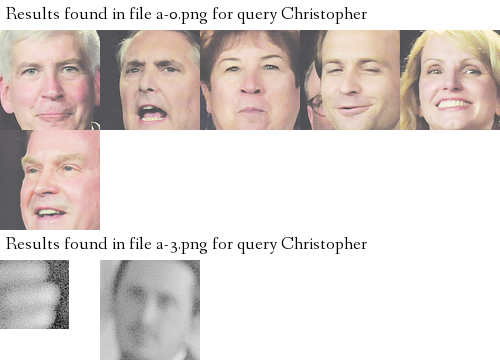

In [8]:
display(output1)

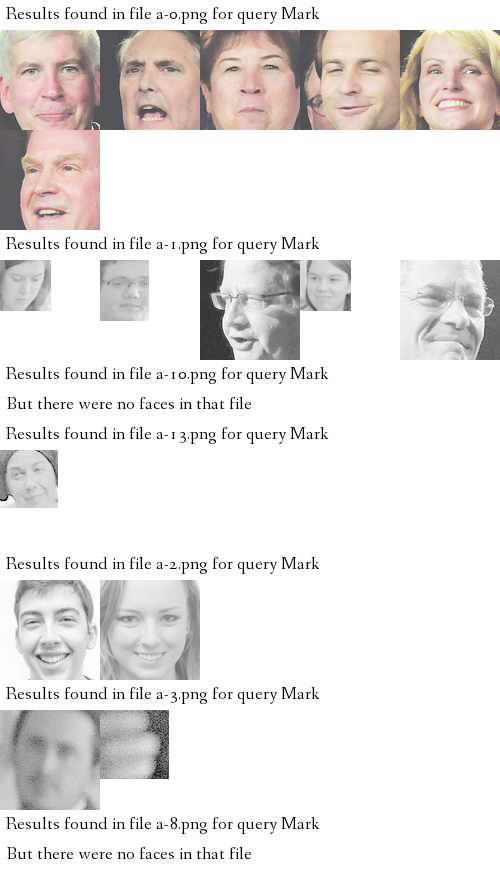

In [9]:
display(output2)